In [15]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation, my_discrete_cmap
from flowrec.utils.py_helper import slice_from_tuple
from flowrec.utils.system import set_gpu
set_gpu(0,0.5)

In [16]:
# def get_loss_one_case(folder):
#     with open(Path(folder,'config.yml'),'r') as f:
#         cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
#         cfg.data_config.data_dir = '.'+cfg.data_config.data_dir
#         rng = np.random.default_rng(cfg.data_config.randseed)

#     x_base = 132
#     triangle_base_coords = [49,80]
#     (ux,uy,pp) = simulation.read_data(cfg.data_config.data_dir,x_base)
#     x = np.stack([ux,uy,pp],axis=0)
#     # remove parts where uz is not zero
#     s = slice_from_tuple(cfg.data_config.slice_to_keep)
#     x = x[s]

#     [x_train,x_val,x_test], _ = data_utils.data_partition(x,
#         1,
#         cfg.data_config.train_test_split,
#         REMOVE_MEAN=cfg.data_config.remove_mean,
#         SHUFFLE=cfg.data_config.shuffle
#     ) # Do not shuffle, do not remove mean for training with physics informed loss

#     [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
#     [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
#     [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

#     datainfo = data_utils.DataMetadata(
#         re = cfg.data_config.re,
#         discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
#         axis_index=[0,1,2],
#         problem_2d=True
#     ).to_named_tuple()

#     u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
#     u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)

#     std_data = np.std(x,axis=(1,2,3),ddof=1)
#     std_n = data_utils.get_whitenoise_std(cfg.data_config.snr,std_data)
#     noise_ux = rng.normal(scale=std_n[0],size=x[0,...].shape)
#     noise_uy = rng.normal(scale=std_n[1],size=x[1,...].shape)
#     noise_pp = rng.normal(scale=std_n[2],size=x[2,...].shape)
#     noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
#     x_noisy = x + noise

#     [x_train_n,x_val_n,x_test_n], _ = data_utils.data_partition(x_noisy,
#         1,
#         cfg.data_config.train_test_split,
#         REMOVE_MEAN=cfg.data_config.remove_mean,
#         randseed=cfg.data_config.randseed,
#         SHUFFLE=cfg.data_config.shuffle
#     ) # Do not shuffle, do not remove mean for training with physics informed loss
#     [ux_train_n,uy_train_n,pp_train_n] = np.squeeze(np.split(x_train_n,3,axis=0))
#     [ux_val_n,uy_val_n,pp_val_n] = np.squeeze(np.split(x_val_n,3,axis=0))
#     [ux_test_n,uy_test_n,pp_test_n] = np.squeeze(np.split(x_test_n,3,axis=0))

#     ## normalise
#     if cfg.data_config.normalise:
#         [ux_train_normal_n,uy_train_normal_n,pp_train_normal_n], train_minmax = data_utils.normalise(ux_train_n,uy_train_n,pp_train_n)
#         [ux_val_normal_n,uy_val_normal_n,pp_val_normal_n], val_minmax = data_utils.normalise(ux_val_n,uy_val_n,pp_val_n)
#         [ux_test_normal_n,uy_test_normal_n,pp_test_normal_n], test_minmax = data_utils.normalise(ux_test_n,uy_test_n,pp_test_n)
#         ## take input
#         pb_train = simulation2d.take_measurement_base(pp_train_normal_n,ly=triangle_base_coords,centrex=0)
#         pb_val = simulation2d.take_measurement_base(pp_val_normal_n,ly=triangle_base_coords,centrex=0)
#         pb_test = simulation2d.take_measurement_base(pp_test_normal_n,ly=triangle_base_coords,centrex=0)
#     else:
#         ## take input
#         pb_train = simulation2d.take_measurement_base(pp_train_n,ly=triangle_base_coords,centrex=0)
#         pb_val = simulation2d.take_measurement_base(pp_val_n,ly=triangle_base_coords,centrex=0)
#         pb_test = simulation2d.take_measurement_base(pp_test_n,ly=triangle_base_coords,centrex=0)

#     pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
#     pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

#     u_train_n = np.stack((ux_train_n,uy_train_n,pp_train_n),axis=-1)
#     u_test_n = np.stack((ux_test_n,uy_test_n,pp_test_n),axis=-1)


#     ## predict
#     state = state_utils.restore_trainingstate(folder,'state')
#     _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
#     mdl = make_model(cfg.model_config)
#     rng_mdl = jax.random.PRNGKey(cfg.train_config.randseed)
#     pb_train_batch = np.array_split(pb_train,2,0)
#     pred_train = []
#     for inn in pb_train_batch:
#         pred_train.append(mdl.apply(state.params,rng_mdl,inn,TRAINING=False))
#     pred_train = np.concatenate(pred_train)
#     pred_test = mdl.apply(state.params,rng_mdl,pb_test,TRAINING=False)
#     if cfg.data_config.normalise:
#         pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
#         pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)


#     rel_l2_train = losses.relative_error(pred_train,u_train)
#     rel_l2_test = losses.relative_error(pred_test,u_test)

#     rel_l2_noisy_train = losses.relative_error(u_train_n,u_train)
#     rel_l2_noisy_test = losses.relative_error(u_test_n,u_test)

#     print(f'testing loss of run {str(folder)}:  {rel_l2_test}')

#     return (rel_l2_train,rel_l2_test),(rel_l2_noisy_train,rel_l2_noisy_test)

In [17]:
# def get_summary(result_dir:Path):
#     repeat_dir = result_dir.iterdir()
#     loss = []
#     loss_noisy_data = []

#     ## load data
#     for folder in repeat_dir:
#         l, d = get_loss_one_case(folder)
#         loss.append(l)
#         loss_noisy_data.append(d)
    
#     return np.array(loss), np.array(loss_noisy_data)

In [18]:
# l_snr20_3,ln_snr20_3 = get_summary(Path('../local_results/draft/snr20_3/'))
# l_snr20_mean3,ln_snr20_mean3 = get_summary(Path('../local_results/draft/snr20_mean3/'))
# l_snr20_classic,ln_snr20_classic = get_summary(Path('../local_results/draft/snr20_classic/'))

In [19]:
# l_snr10_3,ln_snr10_3 = get_summary(Path('../local_results/draft/snr10_3/'))
# l_snr10_mean3,ln_snr10_mean3 = get_summary(Path('../local_results/draft/snr10_mean3/'))
# l_snr10_classic,ln_snr10_classic = get_summary(Path('../local_results/draft/snr10_classic/'))

In [20]:
# l_snr5_3,ln_snr5_3 = get_summary(Path('../local_results/draft/snr5_3/'))
# l_snr5_mean3,ln_snr5_mean3 = get_summary(Path('../local_results/draft/snr5_mean3/'))
# l_snr5_classic,ln_snr5_classic = get_summary(Path('../local_results/draft/snr5_classic/'))

## Load summary file

In [21]:
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr20_classic/summary.h5')) as hf:
    l_snr20_classic_train = np.array(hf.get('runs_loss_train'))
    l_snr20_classic_val = np.array(hf.get('runs_loss_val'))
    lmean_snr20_classic = np.array([np.mean(l_snr20_classic_train[:,0]), np.mean(l_snr20_classic_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr20_classic = np.array([np.std(l_snr20_classic_train[:,0]), np.std(l_snr20_classic_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr20_classic)
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr20_3/summary.h5')) as hf:
    l_snr20_3_train = np.array(hf.get('runs_loss_train'))
    l_snr20_3_val = np.array(hf.get('runs_loss_val'))
    lmean_snr20_3 = np.array([np.mean(l_snr20_3_train[:,0]), np.mean(l_snr20_3_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr20_3 = np.array([np.std(l_snr20_3_train[:,0]), np.std(l_snr20_3_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr20_3)
# with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr20_mean3/summary.h5')) as hf:
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr20_3/summary.h5')) as hf:
    l_snr20_mean3_train = np.array(hf.get('runs_loss_train'))
    l_snr20_mean3_val = np.array(hf.get('runs_loss_val'))
    lmean_snr20_mean3 = np.array([np.mean(l_snr20_mean3_train[:,0]), np.mean(l_snr20_mean3_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr20_mean3 = np.array([np.std(l_snr20_mean3_train[:,0]), np.std(l_snr20_mean3_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr20_mean3)

[0.04037676 0.05775257]
[0.07721486 0.07783008]
[0.07721486 0.07783008]


In [22]:
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr10_classic/summary.h5')) as hf:
    l_snr10_classic_train = np.array(hf.get('runs_loss_train'))
    l_snr10_classic_val = np.array(hf.get('runs_loss_val'))
    lmean_snr10_classic = np.array([np.mean(l_snr10_classic_train[:,0]), np.mean(l_snr10_classic_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr10_classic = np.array([np.std(l_snr10_classic_train[:,0]), np.std(l_snr10_classic_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr10_classic)
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr10_3/summary.h5')) as hf:
    l_snr10_3_train = np.array(hf.get('runs_loss_train'))
    l_snr10_3_val = np.array(hf.get('runs_loss_val'))
    lmean_snr10_3 = np.array([np.mean(l_snr10_3_train[:,0]), np.mean(l_snr10_3_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr10_3 = np.array([np.std(l_snr10_3_train[:,0]), np.std(l_snr10_3_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr10_3)
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr10_mean3/summary.h5')) as hf:
    l_snr10_mean3_train = np.array(hf.get('runs_loss_train'))
    l_snr10_mean3_val = np.array(hf.get('runs_loss_val'))
    lmean_snr10_mean3 = np.array([np.mean(l_snr10_mean3_train[:,0]), np.mean(l_snr10_mean3_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr10_mean3 = np.array([np.std(l_snr10_mean3_train[:,0]), np.std(l_snr10_mean3_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr10_mean3)

[0.51714146 0.5171442 ]
[0.09880457 0.10452387]
[0.08538376 0.09402973]


In [23]:
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr5_classic/summary.h5')) as hf:
    l_snr5_classic_train = np.array(hf.get('runs_loss_train'))
    l_snr5_classic_val = np.array(hf.get('runs_loss_val'))
    lmean_snr5_classic = np.array([np.mean(l_snr5_classic_train[:,0]), np.mean(l_snr5_classic_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr5_classic = np.array([np.std(l_snr5_classic_train[:,0]), np.std(l_snr5_classic_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr5_classic)
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr5_3/summary.h5')) as hf:
    l_snr5_3_train = np.array(hf.get('runs_loss_train'))
    l_snr5_3_val = np.array(hf.get('runs_loss_val'))
    lmean_snr5_3 = np.array([np.mean(l_snr5_3_train[:,0]), np.mean(l_snr5_3_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr5_3 = np.array([np.std(l_snr5_3_train[:,0]), np.std(l_snr5_3_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr5_3)
with h5py.File(Path('../local_results/2dtriangle/repeat_noisy/snr5_mean3/summary.h5')) as hf:
    l_snr5_mean3_train = np.array(hf.get('runs_loss_train'))
    l_snr5_mean3_val = np.array(hf.get('runs_loss_val'))
    lmean_snr5_mean3 = np.array([np.mean(l_snr5_mean3_train[:,0]), np.mean(l_snr5_mean3_val[:,0])]) # mean over the repeats [rel_l2 train, rel_l2 val]
    lstd_snr5_mean3 = np.array([np.std(l_snr5_mean3_train[:,0]), np.std(l_snr5_mean3_val[:,0])]) # std over the repeats [rel_l2 train, rel_l2 val]
    print(lmean_snr5_mean3)

[0.21241164 0.24144816]
[0.15897748 0.19017467]
[0.18297008 0.21417117]


In [24]:
l_mean_classic = []
l_mean_classic.append(lmean_snr20_classic)
l_mean_classic.append(lmean_snr10_classic)
l_mean_classic.append(lmean_snr5_classic)
l_mean_classic = np.array(l_mean_classic)*100
l_std_classic = []
l_std_classic.append(lstd_snr20_classic)
l_std_classic.append(lstd_snr10_classic)
l_std_classic.append(lstd_snr5_classic)
l_std_classic = np.array(l_std_classic)*100

l_mean_3 = []
l_mean_3.append(lmean_snr20_3)
l_mean_3.append(lmean_snr10_3)
l_mean_3.append(lmean_snr5_3)
l_mean_3 = np.array(l_mean_3)*100
l_std_3 = []
l_std_3.append(lstd_snr20_3)
l_std_3.append(lstd_snr10_3)
l_std_3.append(lstd_snr5_3)
l_std_3 = np.array(l_std_3)*100

l_mean_mean3 = []
l_mean_mean3.append(lmean_snr20_mean3)
l_mean_mean3.append(lmean_snr10_mean3)
l_mean_mean3.append(lmean_snr5_mean3)
l_mean_mean3 = np.array(l_mean_mean3)*100
l_std_mean3 = []
l_std_mean3.append(lstd_snr20_mean3)
l_std_mean3.append(lstd_snr10_mean3)
l_std_mean3.append(lstd_snr5_mean3)
l_std_mean3 = np.array(l_std_mean3)*100

In [25]:
# l_mean_classic - rows: 20,10,5 snr. columns: training,testing

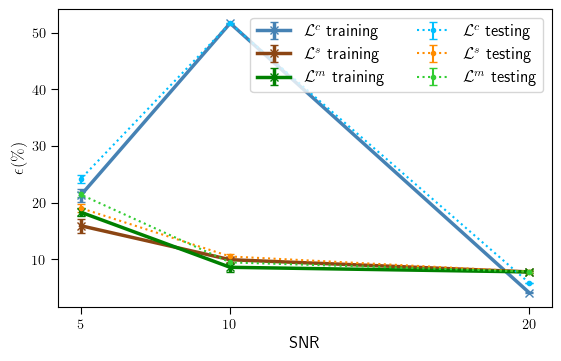

In [27]:
snr = [20,10,5]
plt.figure(figsize=(5.5,3.5))
ax = plt.subplot(111)

ax.errorbar(snr,l_mean_classic[:,0],yerr=l_std_classic[:,0],label='$\mathcal{L}^c$ training',marker='x',color='steelblue',linewidth=2.5)
ax.errorbar(snr,l_mean_3[:,0],yerr=l_std_3[:,0],label='$\mathcal{L}^s$ training',marker='x',color='saddlebrown',linewidth=2.5)
ax.errorbar(snr,l_mean_mean3[:,0],yerr=l_std_mean3[:,0],label='$\mathcal{L}^m$ training',marker='x',color='green',linewidth=2.5)

ax.errorbar(snr,l_mean_classic[:,1],yerr=l_std_classic[:,1],label='$\mathcal{L}^c$ testing',marker='.',color='deepskyblue',linestyle=':')
ax.errorbar(snr,l_mean_3[:,1],yerr=l_std_3[:,1],label='$\mathcal{L}^s$ testing',marker='.',linestyle=':',color='darkorange')
ax.errorbar(snr,l_mean_mean3[:,1],yerr=l_std_mean3[:,1],label='$\mathcal{L}^m$ testing',marker='.',linestyle=':',color='limegreen',)

ax.legend(ncol=2)
ax.set_ylabel('$\epsilon (\%)$')
ax.set_xticks([5,10,20])
ax.set_xlabel('SNR')
# ax.set_yscale('log')
# plt.ylim([0,70])
# plt.savefig('./figs/noisy_compare_lossfn')
plt.show()